In [1]:
#This script produces visualizations of the exact log likelihood surfaces with 95% approximate confidence regions
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Polygon as patch_polygon

In [2]:
#Load exact likelihood surfaces and neural likelihood surfaces (both uncalibrated and calibrated)
image_size = 25
image_name = str(image_size) + "_by_" + str(image_size)
local_folder = "/home/juliatest/Dropbox/likelihood_free_inference/neural_likelihood/gaussian_process"
exact_likelihood_surfaces_file = (local_folder + "/evaluate_nn/generate_data/data/" + image_name + 
                                  "/single/reps/200/evaluation_ll_fields_9_by_9_density_" 
               + image_name + "_200.npy")
exact_likelihood_surfaces = np.load(exact_likelihood_surfaces_file)

number_of_parameters = 81
number_of_reps = 200
#first column is variance and second is lengthscale
parameter_matrix = np.load((local_folder + "/evaluate_nn/generate_data/data/" + image_name + 
                            "/single/reps/200/evaluation_parameters_9_by_9_density_" + image_name + "_200.npy"))
parameter_matrix = parameter_matrix[:,0,:]
possible_lengthscales = [round(.05*i,2) for i in range(1, 41)]
possible_variances = [round(.05*i,2) for i in range(1, 41)]
#Cut off value that corresponds to 95 percent coverage for chi-distribution with 2 degrees of freedom (dimension of parameter space)
C = 5.99

In [3]:
#This function produces the 95 percent approximate confidence region over the parameter grid for a given exact log likelihood surface
    #parameters:
        #exact_likelihood_surface: 40 by 40 matrix, exact log likelihood surface for a given realization of the GP
        #possible_lengthscales: values of lengthscales on the parameter grid
        #possible_variances: values of variances on the parameter grid
        #C: cut off value that corresponds to 95 percent coverage for chi-distribution with 2 degrees of freedom (dimension of parameter space)
def produce_exact_likelihood_confidence_region(exact_likelihood_surface, possible_lengthscales, possible_variances, C):

    max_field_value = np.max(exact_likelihood_surface)
    field_difference = 2*(max_field_value - exact_likelihood_surface)
    confidence_grid = np.where(field_difference <= C, 1, 0)
    
    #if we assume convex surface

    variance_values = []
    lengthscale_values = []
    
    for i in range(0, confidence_grid.shape[0]):
        if(np.array(np.where((confidence_grid[i,:]) == 1)).any()):
            #min_val = (np.array(np.where((confidence_grid[i,:]) == 1))).min()
            max_val = (np.array(np.where((confidence_grid[i,:]) == 1))).max()
            variance_values.append(possible_variances[i])
            lengthscale_values.append(possible_lengthscales[max_val])

    for i in range((confidence_grid.shape[0] - 1), 0, -1):
        if(np.array(np.where((confidence_grid[i,:]) == 1)).any()):
            min_val = (np.array(np.where((confidence_grid[i,:]) == 1))).min()
            variance_values.append(possible_variances[i])
            lengthscale_values.append(possible_lengthscales[min_val])

    confidence_region = np.zeros((len(variance_values),2))
    confidence_region[:,0] = lengthscale_values
    confidence_region[:,1] = variance_values

    return confidence_region

#Produce visualization of exact log likelihood surface with 95 percent approximate confidence region
    #parameters:
        #exact_likelihood_surface: 40 by 40 matrix, exact log likelihood surface for a given realization of the GP
        #possible_lengthscales: values of lengthscales on the parameter grid
        #possible_variances: values of variances on the parameter grid
        #C: cut off value that corresponds to 95 percent coverage for chi-distribution with 2 degrees of freedom (dimension of parameter space)
        #true_lengthscale: the lengthscale which generated the realization of the gp
        #true_variance: the variance which generated the realization of the gp
        #irep: the number referring to the specific realization for the given parameter on the grid
        #constant: the color scale for the visualization is set to span the maximum value of the surface and the maximum value of the surface minuse constant
        #single_or_multi: str that indicates which type (single realization or multiple realization)
def produce_exact_likelihood_confidence_region_surface(exact_likelihood_surface, possible_lengthscales, possible_variances, C,
                                                        true_lengthscale, true_variance, irep, constant, single_or_multi):

    confidence_region = produce_exact_likelihood_confidence_region(exact_likelihood_surface, possible_lengthscales, possible_variances, C)
    polygon_figure = patch_polygon(confidence_region, facecolor = "none", edgecolor = "black", linewidth = 5)
    fig, ax = plt.subplots(figsize = (10,10))
    x = np.linspace(.05, 2, 40)
    y = np.linspace(.05, 2, 40)
    X, Y = np.meshgrid(x, y)
    exact_likelihood_surface[exact_likelihood_surface == np.inf] == np.min(exact_likelihood_surface[exact_likelihood_surface != np.inf])
    Z = exact_likelihood_surface
    Z = Z.reshape((40, 40))
    max_indices = np.unravel_index(np.argmax(Z, axis=None), Z.shape)
    max_lengthscale = possible_lengthscales[max_indices[1]]
    max_variance = possible_variances[max_indices[0]]
    cp = ax.contourf(X, Y, Z, vmin = (np.amax(Z) -constant), vmax = np.amax(Z), levels = 120000)
    ax.add_patch(polygon_figure)
    ax.scatter(true_lengthscale, true_variance, s = 600, marker = "*", c = "black")
    ax.scatter(max_lengthscale, max_variance, s = 600, marker = "o", c= "red")
    legend_elements = [Line2D([0], [0], marker='*', color='w', label='True',
                          markerfacecolor='black', markersize=40), 
                          Line2D([0], [0], marker='o', color='w', label='Estimate',
                          markerfacecolor='red', markersize=30), Line2D([0], [0], marker='_', color='black', label='95% CR',
                          markerfacecolor='none', markersize=40, linewidth = 8)]
    ax.legend(handles = legend_elements, facecolor='white', framealpha=1, fontsize="25")
    ax.set_xlabel("length scale", fontsize = 40)
    ax.set_ylabel("variance", fontsize = 40)
    plt.yticks(fontsize=20)
    plt.xticks(fontsize =20)
    plt.title("Exact Likelihood", fontsize = 45)
    plt.tight_layout()
    fig_name = (local_folder + 
                "/evaluate_nn/visualizations/visualize_approximate_confidence_regions/visualizations/exact_likelihood/" +
                single_or_multi + "/reps/200/" + str(constant) + 
                "_exact_likelihood_approximate_confidence_region_95_variance_" + str(round(true_variance, 2)) 
                + "_lengthscale_" + str(round(true_lengthscale, 2)) + "_rep_" + str(irep) + ".png")
    plt.savefig(fig_name)

Locator attempting to generate 98744 ticks ([-8629.44, ..., -730.0]), which exceeds Locator.MAXTICKS (1000).


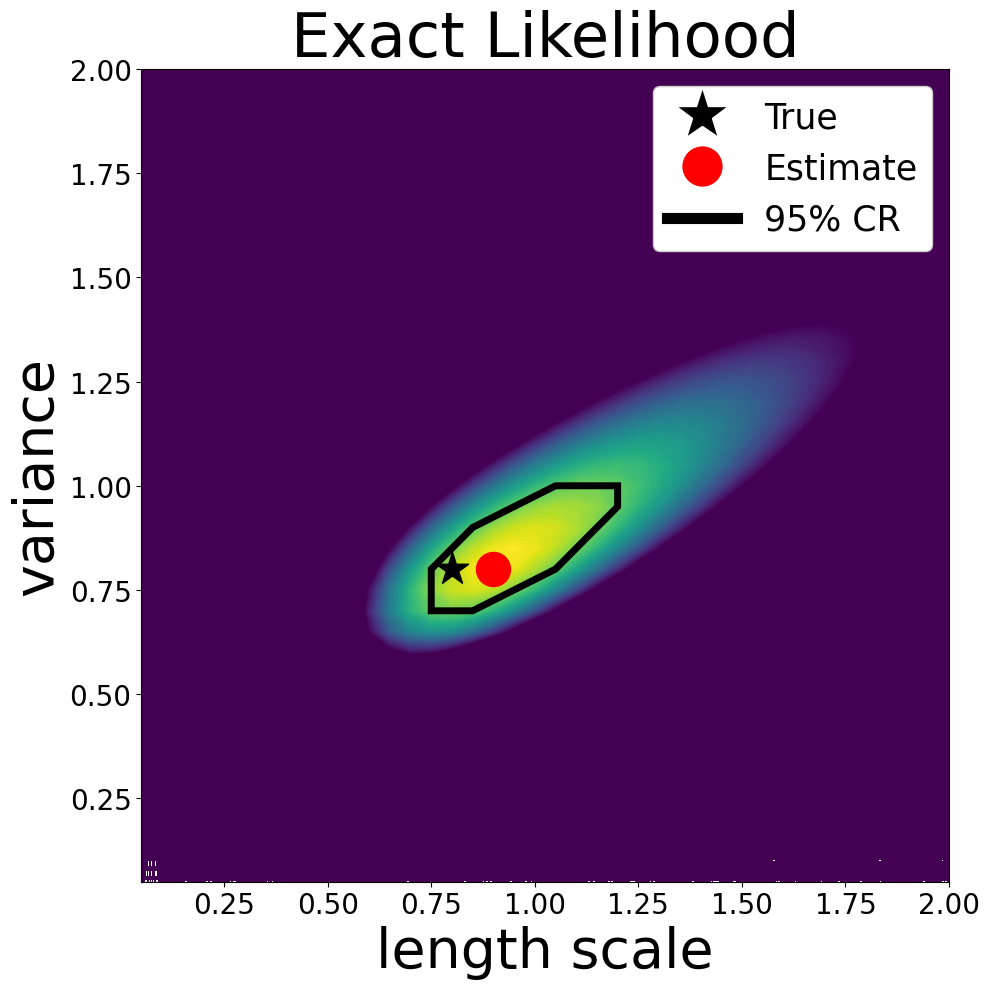

In [4]:
#Single realization case
#These are the indices for the 4 by 4 grid over the parameter space starting at (.4,.4) and increasing by increments of .4
indices = [10,12,14,16,28,30,32,34,46,48,50,52,64,66,68,70]
constant = 10
single_or_multi = "single"

for ipred in [30]:
    for irep in range(12,13):
        #first column is variance
        current_lengthscale = parameter_matrix[ipred,1]
        current_variance = parameter_matrix[ipred,0]
        produce_exact_likelihood_confidence_region_surface(exact_likelihood_surfaces[ipred, irep,:,:], possible_lengthscales,
                                                           possible_variances, C, current_lengthscale, current_variance, irep,
                                                           constant, single_or_multi)

In [5]:
multi_exact_likelihood_surfaces_file = (local_folder + "/evaluate_nn/generate_data/data/" + image_name + 
                                  "/multi/5/reps/200/evaluation_ll_fields_9_by_9_density_" 
               + image_name + "_multi_5_200.npy")
multi_exact_likelihood_surfaces = np.load(multi_exact_likelihood_surfaces_file)

In [ ]:
#Multiple realization case
#These are the indices for the 4 by 4 grid over the parameter space starting at (.4,.4) and increasing by increments of .4
indices = [10,12,14,16,28,30,32,34,46,48,50,52,64,66,68,70]
constant = 10
single_or_multi = "multi/5"
for ipred in indices:
    for irep in range(0,1):
        #first column is variance
        current_lengthscale = parameter_matrix[ipred,1]
        current_variance = parameter_matrix[ipred,0]
        produce_exact_likelihood_confidence_region_surface(multi_exact_likelihood_surfaces[ipred,irep,:,:],
                                                           possible_lengthscales, possible_variances, C,
                                                           current_lengthscale, current_variance, irep,
                                                           constant, single_or_multi)